# Gridworld DQN — Assignment-(2)
# Environment: start (2,0), wall (1,1), trap (1,3), goal (0,3); actions 0=N,1=E,2=S,3=W; slip 80/10/10.


In [ ]:

import random, time, platform
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42); random.seed(42)




## Environment: 3×4 Gridworld
- Wall at `(1,1)`; goal `(2,3)`; trap `(1,3)`  
- Step cost –0.04 except terminals (+1 / –1) 

In [ ]:


class Gridworld:
    def __init__(self):
        self.rows, self.cols = 3, 4
        self.start = (2, 0)
        self.wall  = (1, 1)
        self.goal  = (0, 3)
        self.trap  = (1, 3)

        self.actions = [0, 1, 2, 3]  # 0=N,1=E,2=S,3=W
        self.action_vecs = {0:(-1,0), 1:(0,1), 2:(1,0), 3:(0,-1)}
        self.left_of  = {0:3, 1:0, 2:1, 3:2}
        self.right_of = {0:1, 1:2, 2:3, 3:0}
        self.reset()

    def reset(self):
        self.s = self.start
        return self.s

    def in_bounds(self, r, c): return 0 <= r < self.rows and 0 <= c < self.cols
    def is_wall(self, rc):      return rc == self.wall
    def is_terminal(self, rc):  return rc == self.goal or rc == self.trap

    def step(self, a):
        rnd = random.random()
        if rnd < 0.8:   a_eff = a
        elif rnd < 0.9: a_eff = self.left_of[a]
        else:           a_eff = self.right_of[a]

        dr, dc = self.action_vecs[a_eff]
        nr, nc = self.s[0] + dr, self.s[1] + dc
        if not self.in_bounds(nr, nc) or self.is_wall((nr, nc)):
            nr, nc = self.s

        s2 = (nr, nc)
        if s2 == self.goal: r, done = 1.0, True
        elif s2 == self.trap: r, done = -1.0, True
        else: r, done = -0.04, False

        self.s = s2
        return s2, r, done, {}

    def all_states(self):
        for r in range(self.rows):
            for c in range(self.cols):
                if (r,c) != self.wall:
                    yield (r,c)

env = Gridworld()
print("Layout:", env.start, env.wall, env.trap, env.goal)


Layout: (2, 0) (1, 1) (1, 3) (0, 3)


# State Encoding
Each possible cell in the grid is given a unique index

In [83]:

STATE_ENCODING = 'onehot'

def encode(s):
    r,c = s
    if STATE_ENCODING == 'coords':
        return np.array([r/2.0, c/3.0], dtype=np.float32)
    one = np.zeros(12, dtype=np.float32)
    one[r*4 + c] = 1.0
    return one


## Q-network: 2-layer MLP (NumPy)

- Hidden sizes: 64, 64 (ReLU)
- Output: 4 Q-values for actions **N, S, W, E**
- Stochastic Gradient Descent (SGD) with a fixed learning rate (3e-4).

In [84]:

class MLP:
    def __init__(self, in_dim, hidden=(64,64), out_dim=4):
        h1,h2 = hidden
        rng = np.random.default_rng(123)
        self.W1 = rng.standard_normal((in_dim,h1), dtype=np.float32)*0.1
        self.b1 = np.zeros((h1,), dtype=np.float32)
        self.W2 = rng.standard_normal((h1,h2), dtype=np.float32)*0.1
        self.b2 = np.zeros((h2,), dtype=np.float32)
        self.W3 = rng.standard_normal((h2,out_dim), dtype=np.float32)*0.1
        self.b3 = np.zeros((out_dim,), dtype=np.float32)

    def forward(self, X):
        self.X = X
        self.z1 = X @ self.W1 + self.b1
        self.h1 = np.maximum(self.z1, 0)
        self.z2 = self.h1 @ self.W2 + self.b2
        self.h2 = np.maximum(self.z2, 0)
        self.out = self.h2 @ self.W3 + self.b3
        return self.out

    def backward_and_step(self, dOut, lr=5e-4):
        dW3 = self.h2.T @ dOut; db3 = np.sum(dOut, axis=0)
        dh2 = dOut @ self.W3.T; dz2 = dh2 * (self.z2 > 0)
        dW2 = self.h1.T @ dz2; db2 = np.sum(dz2, axis=0)
        dh1 = dz2 @ self.W2.T; dz1 = dh1 * (self.z1 > 0)
        dW1 = self.X.T @ dz1; db1 = np.sum(dz1, axis=0)
        self.W3 -= lr*dW3; self.b3 -= lr*db3
        self.W2 -= lr*dW2; self.b2 -= lr*db2
        self.W1 -= lr*dW1; self.b1 -= lr*db1

    def clone_from(self, other):
        for k in ["W1","b1","W2","b2","W3","b3"]:
            setattr(self, k, getattr(other,k).copy())



## Replay Buffer & Helpers


In [85]:

class ReplayBuffer:
    def __init__(self, cap): self.buf = deque(maxlen=cap)
    def push(self,s,a,r,s2,d): self.buf.append((s,a,r,s2,d))
    def sample(self, B):
        import random
        batch = random.sample(self.buf, B)
        s,a,r,s2,d = zip(*batch)
        return (np.asarray(s, dtype=object),
                np.asarray(a, dtype=np.int64),
                np.asarray(r, dtype=np.float32),
                np.asarray(s2, dtype=object),
                np.asarray(d, dtype=np.float32))
    def __len__(self): return len(self.buf)

def huber(delta, c=1.0):
    absd = np.abs(delta); quad = np.minimum(absd,c); lin = absd - quad
    return 0.5*quad**2 + c*lin

def eval_policy(env, net, episodes=20, max_steps=200):
    rets = []
    for _ in range(episodes):
        s = env.reset(); done=False; t=0; total=0.0
        while not done and t < max_steps:
            q = net.forward(encode(s)[None,:].astype(np.float32))[0]
            a = int(np.argmax(q))
            s,r,done,_ = env.step(a)
            total += float(r); t += 1
        rets.append(total)
    return float(np.mean(rets)), rets


In [86]:

# Hyperparameters
GAMMA = 0.99
LR = 3e-4
BATCH_SIZE = 64
BUFFER_SIZE = 20_000
TARGET_SYNC_EVERY = 600
TRAIN_STEPS = 150_000
EVAL_EVERY = 2_000
EVAL_EPISODES = 20
MAX_STEPS_PER_EPISODE = 200
USE_HUBER = True

env = Gridworld()
in_dim = len(encode(env.start))
q_net  = MLP(in_dim, (64,64), 4)
tgt_net = MLP(in_dim, (64,64), 4); tgt_net.clone_from(q_net)

buf = ReplayBuffer(BUFFER_SIZE)
while len(buf) < 1000:
    s = env.reset(); done=False; t=0
    while not done and t < MAX_STEPS_PER_EPISODE:
        a = random.randrange(4)
        s2,r,done,_ = env.step(a)
        buf.push(s,a,r,s2,done)
        s = s2; t += 1
print("Replay seeded:", len(buf))


Replay seeded: 1006



## Train the DQN Agent


In [87]:

def epsilon_by_step(step, start=1.0, end=0.05, decay_steps=15000):
    if step >= decay_steps: return end
    return start - (start-end)*(step/decay_steps)

global_step = 0
train_losses, eval_steps, eval_returns = [], [], []
s = env.reset(); done = False
t0 = time.time(); last = t0

while global_step < TRAIN_STEPS:
    eps = epsilon_by_step(global_step)
    if random.random() < eps:
        a = random.randrange(4)
    else:
        q = q_net.forward(encode(s)[None,:].astype(np.float32))[0]
        a = int(np.argmax(q))

    s2,r,done,_ = env.step(a)
    buf.push(s,a,r,s2,done)

    if len(buf) >= BATCH_SIZE:
        S,A,R,S2,D = buf.sample(BATCH_SIZE)
        X  = np.stack([encode(si)  for si  in S], axis=0).astype(np.float32)
        X2 = np.stack([encode(si2) for si2 in S2], axis=0).astype(np.float32)

        Q     = q_net.forward(X)
        Q2_tg = tgt_net.forward(X2)
        maxQ2 = np.max(Q2_tg, axis=1)
        y = R + (1.0 - D) * GAMMA * maxQ2

        Q_sa = Q[np.arange(BATCH_SIZE), A]
        diff = (Q_sa - y)

        if USE_HUBER:
            clip = 1.0
            d = np.where(np.abs(diff) <= clip, diff, clip*np.sign(diff))
            loss = float(np.mean(huber(y - Q_sa, clip)))
        else:
            d = diff
            loss = float(np.mean(0.5*(y - Q_sa)**2))

        dOut = np.zeros_like(Q, dtype=np.float32)
        dOut[np.arange(BATCH_SIZE), A] = d / BATCH_SIZE
        q_net.backward_and_step(dOut, lr=LR)
        train_losses.append(loss)

    if global_step % TARGET_SYNC_EVERY == 0 and global_step > 0:
        tgt_net.clone_from(q_net)

    if global_step % EVAL_EVERY == 0 and global_step > 0:
        mean_ret, _ = eval_policy(env, q_net, episodes=EVAL_EPISODES, max_steps=MAX_STEPS_PER_EPISODE)
        eval_steps.append(global_step); eval_returns.append(mean_ret)

    s = env.reset() if done else s2
    done = False if done else done
    global_step += 1

    if global_step % 1000 == 0:
        now = time.time()
        print(f"{global_step:>6} steps | {1000/(now-last):.1f} steps/s | total {now-t0:.1f}s | eps={eps:.3f}")
        last = now

print("Training complete.")


  1000 steps | 2955.2 steps/s | total 0.3s | eps=0.937
  2000 steps | 2898.8 steps/s | total 0.7s | eps=0.873
  3000 steps | 2717.0 steps/s | total 1.1s | eps=0.810
  4000 steps | 2965.7 steps/s | total 1.4s | eps=0.747
  5000 steps | 2718.4 steps/s | total 1.8s | eps=0.683
  6000 steps | 2999.3 steps/s | total 2.1s | eps=0.620
  7000 steps | 2680.4 steps/s | total 2.5s | eps=0.557
  8000 steps | 2864.5 steps/s | total 2.8s | eps=0.493
  9000 steps | 2589.4 steps/s | total 3.2s | eps=0.430
 10000 steps | 2808.5 steps/s | total 3.6s | eps=0.367
 11000 steps | 2549.3 steps/s | total 3.9s | eps=0.303
 12000 steps | 2760.0 steps/s | total 4.3s | eps=0.240
 13000 steps | 2656.7 steps/s | total 4.7s | eps=0.177
 14000 steps | 2833.8 steps/s | total 5.0s | eps=0.113
 15000 steps | 2832.1 steps/s | total 5.4s | eps=0.050
 16000 steps | 2840.4 steps/s | total 5.7s | eps=0.050
 17000 steps | 2797.1 steps/s | total 6.1s | eps=0.050
 18000 steps | 2871.9 steps/s | total 6.4s | eps=0.050
 19000 ste

# Plots

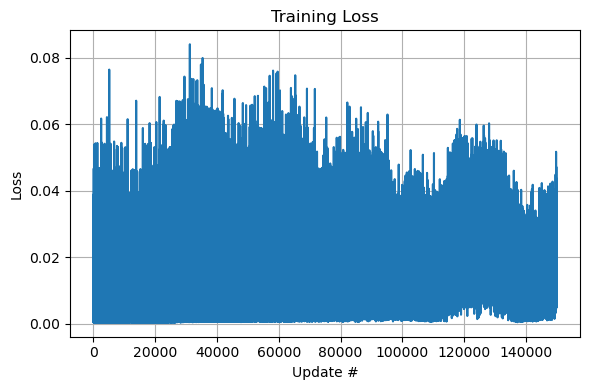

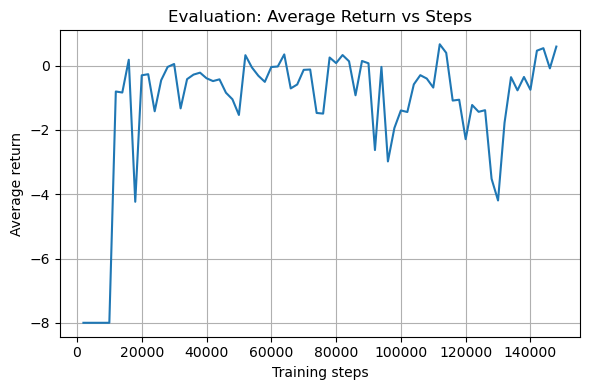

In [ ]:

plt.figure(figsize=(6,4)); 
plt.title("Training Loss"); 
plt.plot(train_losses); 
plt.grid(True); 
plt.xlabel("Update #"); 
plt.ylabel("Loss"); 
plt.tight_layout(); 
plt.show()
if len(eval_steps)>0:
    plt.figure(figsize=(6,4)); 
    plt.title("Evaluation: Average Return vs Steps"); 
    plt.plot(eval_steps, eval_returns); 
    plt.grid(True); 
    plt.xlabel("Training steps"); 
    plt.ylabel("Average return"); 
    plt.tight_layout(); 
    plt.show()


# Greedy Policy Map (learned)

In [ ]:

arrow = {0:"↑", 1:"→", 2:"↓", 3:"←"}
policy = [["" for _ in range(env.cols)] for __ in range(env.rows)]
for r in range(env.rows):
    for c in range(env.cols):
        s = (r,c)
        if s == env.wall: policy[r][c] = "###"; continue
        if s == env.goal: policy[r][c] = "+1";  continue
        if s == env.trap: policy[r][c] = "-1";  continue
        q = q_net.forward(encode(s)[None,:].astype(np.float32))[0]
        a = int(np.argmax(q))
        policy[r][c] = arrow[a]
print("Greedy Policy Map (row 0 is top):")
for r in range(env.rows):
    print(" | ".join(policy[r]))


Greedy Policy Map (row 0 is top):
→ | → | → | +1
↑ | ### | ↑ | -1
→ | → | ↑ | ←
